<a href="https://colab.research.google.com/github/dadang6842/AI-study/blob/main/assignments/Univariate_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- 위 블로그 참고

### 기본 개념
Univariate LSTM
- 과거 한 가지 변수(예: 기온)만으로 미래 값을 예측

Multivariate LSTM
- 과거 여러 변수(예: 기온, 습도, 풍속 등)를 함께 사용해 예측

Single-Step Forecasting
- 과거 T개 시점의 데이터를 보고 바로 다음 시점(한 스텝)만 예측
- 출력층(Dense) 유닛 수 = 1

Multi-Step Forecasting
- 과거 T개 시점의 데이터를 보고 미래 M개 시점을 한 번에 예측
- 출력층 유닛 수 = M (출력 벡터 차원이 M)

(samples, timesteps. features)
- samples: 학습용 샘플 총 개수
- timesteps: 한 샘플당 바라보는 과거 시점의 개수
- features: 각 시점에 측정된 변수의 개수

## Data Preparation

In [15]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [16]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

## Vanila LSTM

In [17]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features)) # reshape into [samples, timesteps, features]
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.65567]]


## Stacked LSTM
return_sequences=True
- 3D output -> 다음 LSTM layer에 입력할 수 있게끔

In [18]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[103.64697]]


## Bidirectional LSTM
- 양방향 LSTM
- 순방향 뿐만 아니라 역방향으로도 정보를 추출
- 과거 정보 뿐만 아니라 미래 정보까지 반영하여 양방향 문맥 활용
- Bidirectional(LSTM(...)) 형식으로 사용

In [19]:
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[[101.43526]]


## CNN LSTM
- CNN이 입력의 부분 시퀀스를 해석, 해석 결과들이 모여 LSTM이 처리할 시퀀스를 이룸

과정
1. 원본 시계열 분할
- 전체 시퀀스를 윈도우(window) 방식으로 자르고, (입력 길이=T_in, 출력 길이=T_out) 샘플 생성
2. 부분 시퀀스(subsequence) 생성
- 입력 길이 T_in을 n_seq개의 동일 크기 n_steps로 분할
- T_in = n_seq × n_steps 여야 함
3. 데이터 재구조화
- 원래 (샘플, T_in, 피처) → (샘플, n_seq, n_steps, 피처)
4. CNN 처리
- TimeDistributed(Conv1D/Conv2D, …) 레이어로 각 부분 시퀀스별 특징 맵(feature map) 생성
- TimeDistrubuted() subsequence 축(n_seq가 위치한 축(axis=1)을 따라 Conv1D 연산을 적용
5. LSTM 처리
- CNN 출력 시퀀스 (샘플, n_seq, CNN_피처) → LSTM → 최종 예측

파라미터
- n_seq: 부분 시퀀스 개수, LSTM에 공급되는 타입 스텝 수와 동일
- n_steps: 각 부분 시퀀스의 길이, CNN이 한 번에 보는 시퀀스 길이

kernel_size=1
- 한 번에 1개의 time step만 읽겠다
- 각 시점에 대해 독립적인 특징 추출이 필요하거나, 채널 확장 또는 축소가 필요할 때 사용

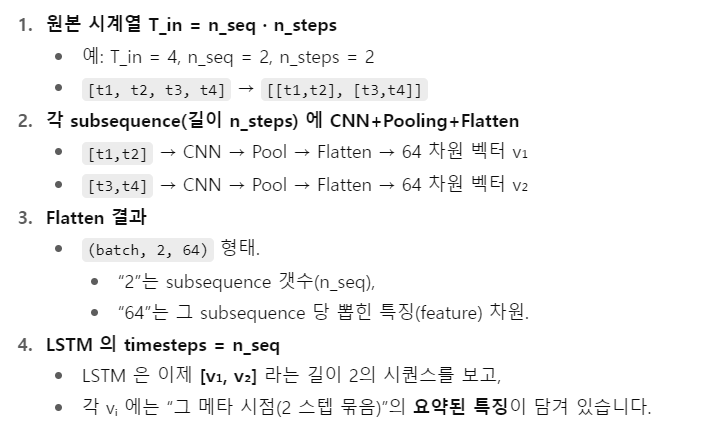

In [21]:
# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

# choose a number of time steps
n_steps = 4

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features))) # n_seq를 런타임에 변경 가능
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=500, verbose=0)

# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[[100.42851]]


## ConvLSTM
- CNN 연산을 LSTM 셀 내부에서 수행함 → 공간 + 시간 정보를 동시에 학습
- 2D 데이터를 처리하기 위해 고안
- 입력 형태: [samples, timesteps, rows, columns, channels]
- 예: (N, 10, 64, 64, 1) → 10장의 64x64 이미지를 시퀀스로 입력
- 시계열 처리 시 row를 1로 설정

CNN-LSTM과 비교
- LSTM 셀 내부에서 Conv 연산 수행
- CNN + LSTM이 한 셀 안에 있어 더 복잡한 패턴을 학습 -> 시공간 정보가 중요한 경우에 사용
- CNN, LSTM을 따로 튜닝할 수 없음
- 구조 복잡
- 5D 입력이 필요해서 전처리 복잡도 상승

In [22]:
# univariate convlstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

# choose a number of time steps
n_steps = 4

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=500, verbose=0)

# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[[101.17176]]
